<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/02_kmeans_datos_sinteticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="figuras/mbit-logo.png" align="right" style="float" width="200">
<font color="#CA3532"><h1 align="left">Clustering</h1></font>
<h2 align="left">Base de datos sintética. K-means (parte 2)</h2>

Primero importamos las librerías que necesitaremos. También activaremos el modo *inline* para los gráficos generados por *matplotlib*. También inicializaremos la semilla del generador de números aleatorios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_moons, make_circles
from numpy import linalg
from matplotlib.patches import Ellipse

%matplotlib inline

Ahora crearemos un problema no supervisado sintético. El objetivo es entender los conceptos principales con este prolema, luego analizaremos bases de datos reales. Usaremos la función "make_blobs" que genera datos con un número especificado de "blobs". Esta función escoge aleatoriamente los centros de los blobs.

Los parámetros que cambiaremos se comentan aquí:

## Funciones para crear y dibujar los datos en el problema de los clusters elipsoidales

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados
        
    return X_rotados

def genera_puntos_gaussiana2D(Npuntos, media, std1, std2, angulo):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * std1 # se multiplica cada atributo por la
    X[1,:] = X[1,:] * std2 # desviación estándar deseada
    X = rota_datos_alrededor_origen(X, angulo)
    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]
    
    return X.T

def genera_puntos_disco2D(Npuntos, media, radio):
    radios  = radio*np.sqrt(np.random.rand(Npuntos))
    angulos = (2*np.pi)*np.random.rand(Npuntos)
    X = np.zeros((Npuntos,2))
    X[:,0] = media[0] + radios*np.cos(angulos)
    X[:,1] = media[1] + radios*np.sin(angulos)    
    return X

def plot_ellipsoid(mean, cov, color, splot, alpha=0.5):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(alpha)
    splot.add_artist(ell)

def plot_ellipsoid_from_data(X, color, splot, alpha=0.5):
    plot_ellipsoid(np.mean(X.T, axis=1), np.cov(X.T), color, splot, alpha)

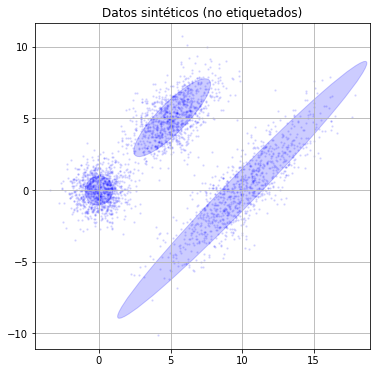

In [3]:
problema = 6

if problema==1:
    Nblobs = 3 # número de "blobs"
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = 0.75) # ancho de cada "blob"    

elif problema==2: # blobs de diferente tamanyo
    Nblobs = 3
    stds = [0.1, 3, 0.1]
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 2000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = stds) # ancho de cada "blob"    

elif problema==3: # dos "lunas" acopladas
    X = make_moons(n_samples=2000, noise=.1, random_state=21)[0]

elif problema==4: # círculo dentro de un círculo
    X = make_circles(n_samples=2000, factor=0.5, noise=.05, random_state=21)[0]
    
elif problema==5: # "Mickey Mouse"
    n_samples = 1000
    X1 = genera_puntos_disco2D(n_samples, [0, 5], 2)
    X2 = genera_puntos_disco2D(n_samples, [10, 5], 2)
    X3 = genera_puntos_disco2D(int(5*5/2/2*n_samples), [5, 0], 5)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)

elif problema==6:
    n_samples = 1000
    #np.random.seed(0)
    X1 = genera_puntos_gaussiana2D(n_samples, [0, 0], 1, 1, 45)
    X2 = genera_puntos_gaussiana2D(n_samples, [10, 0], 3.5, 1, 45)
    X3 = genera_puntos_gaussiana2D(n_samples, [5, 5], 2, 1, 45)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)
    colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
    markers = ['s', 'v', 'o', 'd', 's']
    

    plt.figure(figsize=(6,6))
    splot = plt.subplot(1, 1, 1)
    for Xi,color in zip(Xs,colors):
        plot_ellipsoid_from_data(Xi, 'b', splot, alpha=0.2)    
    
plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.1)
plt.grid()
plt.axis('equal')
plt.title('Datos sintéticos (no etiquetados)');

Ahora usaremos el algoritmo de clustering k-means.
El parámetro principal es el número de clusters. Los otros parámetros se comentan en la celda siguiente y se visualizan los resultados obtenidos por este algoritmo:

In [4]:
X.mean(axis=0)

array([5.03725248, 1.67923635])

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(np.mean(X,axis=0))
print(np.std(X,axis=0))

[-1.13686838e-16  0.00000000e+00]
[1. 1.]


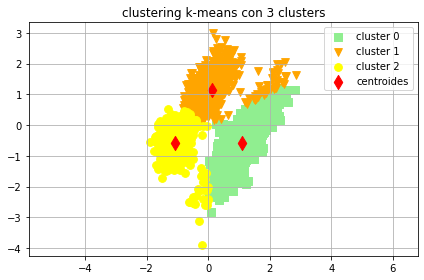

In [6]:
Nclusters = 3    # número de clusters
Nrepetitions = 10 # número de repeticiones (para evitar mínimos locales). Número mínimo: 1
kmeans = KMeans(n_clusters=Nclusters,
                init='random', # random o kmeans++ (más eficiente)
                n_init=Nrepetitions,
                max_iter=500,
                random_state=2)
kmeans.fit(X)

ax = plt.subplot(1,1,1)
colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue', 'darkblue']
markers = ['s', 'v', 'o', 'd', 's']
for i in range(Nclusters):
    plt.scatter(X[kmeans.labels_ == i, 0],
                X[kmeans.labels_ == i, 1],
                s = 60, c = colors[i], marker = markers[i],
                label = 'cluster %d' % (i))

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            s = 100, marker = 'd',
            c='red', label='centroides')
plt.legend()
plt.grid()
plt.axis('equal')
plt.title('clustering k-means con %d clusters' % Nclusters)
plt.tight_layout()

Asume que los clusters tienen igual tamaño y no funciona bien con estos datos.

Uno de los problemas principales es cómo ajustar el número de clusters. Hay muchas estrategias. Una es usando el índice de calidad de clustering "Silhouette" para encontrar este número. Otra es usar otra métrica como el score de Calinski-Harabasz. La siguiente celda implementa estas estrategias:

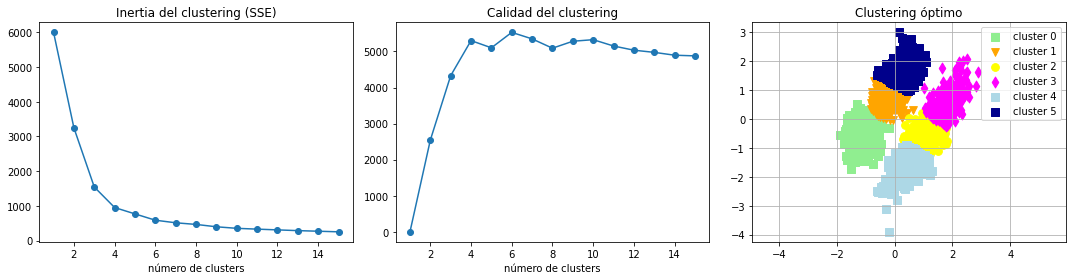

Número de clusters óptimo: 6


In [7]:
Nclusters_max = 15
Nrepetitions = 10
#qmetric = metrics.silhouette_score
qmetric = metrics.calinski_harabasz_score

qualities = []
inertias = []
models = []
for k in range(1,Nclusters_max+1):
    kmeans = KMeans(n_clusters=k,
                    init='k-means++', n_init=Nrepetitions,
                    max_iter=500, random_state=1)
    kmeans.fit(X)
    models.append(kmeans)
    inertias.append(kmeans.inertia_)
    if k >1:
        qualities.append(qmetric(X, kmeans.labels_))
    else:
        qualities.append(0)

fig = plt.figure(figsize=(15,4))

ax = plt.subplot(1,3,1)
plt.plot(range(1,Nclusters_max+1), inertias, marker='o')
plt.xlabel('número de clusters')
plt.title('Inertia del clustering (SSE)')

ax = plt.subplot(1, 3, 2)
plt.plot(range(1,Nclusters_max+1), qualities, marker='o')
plt.xlabel('número de clusters')
plt.title('Calidad del clustering')

ax = plt.subplot(1, 3, 3)
best = pd.Series(qualities).idxmax() # encuentra el índice del mejor modelo
kmeans = models[best]
n_clusters = kmeans.get_params()['n_clusters']
for i in range(n_clusters):
    inds = np.where(kmeans.labels_ == i)[0]
    plt.scatter(X[inds, 0],
                X[inds, 1],
                s = 60,
                c = colors[i%len(colors)], marker = markers[i%len(markers)],
                label = 'cluster %d' % (i))

plt.legend()
plt.grid()
plt.axis('equal')
plt.tight_layout()
plt.title('Clustering óptimo')
plt.show()

print('Número de clusters óptimo: %d' % n_clusters)

Prueba diferentes parámetros y problemas sintéticos para comprender cómo funciona k-means en estos problemas de dos dimensiones.

- ¿Descubre siempre k-means los clusters "reales"?
- ¿Qué ocurre si los "blobs" están "demasiado" cerca?
- ¿Encuentra siempre la estrategia basada en el índice Silhouette el número "real" de clusters?
- ¿Y la basada en el índice Calinski-Harabasz?